# Generative vs. Discriminative Models: Penguins Dataset

## Naive Bayes vs. Logistic Regression


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("successful import")

# random seed for reproducibility
np.random.seed(42)

# set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

successful import


---
## Load Penguins Dataset & Preprocess


In [13]:
print("beginning loading")

penguins = sns.load_dataset('penguins')
print("penguins loaded")

print(f"\nDataset shape: {penguins.shape}")
print(f"\nSpecies counts:\n{penguins['species'].value_counts()}")

# filter for adelie and gentoo
penguins_filtered = penguins[penguins['species'].isin(['Adelie', 'Gentoo'])].copy()
print(f"\nFiltered dataset shape: {penguins_filtered.shape}")
print(f"\nFiltered species distribution:\n{penguins_filtered['species'].value_counts()}")

# clean rows with missing values
penguins_filtered = penguins_filtered.dropna()
print(f"\nDataset shape after removing NaN: {penguins_filtered.shape}")

# select features and target
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = penguins_filtered[feature_columns]
y = penguins_filtered['species']

# target to binary (gentoo = 1, adelie = 0)
y_binary = (y == 'Gentoo').astype(int)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_binary.shape}")
print(f"\nFeature columns: {feature_columns}")
print(f"\nClass distribution: Adelie={sum(y_binary==0)}, Gentoo={sum(y_binary==1)}")

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# scale features
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


beginning loading
penguins loaded

Dataset shape: (344, 7)

Species counts:
species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

Filtered dataset shape: (276, 7)

Filtered species distribution:
species
Adelie    152
Gentoo    124
Name: count, dtype: int64

Dataset shape after removing NaN: (265, 7)

Features shape: (265, 4)
Target shape: (265,)

Feature columns: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

Class distribution: Adelie=146, Gentoo=119

Training set size: 212
Test set size: 53


## 1. Accuracy Comparison

In [18]:
# train
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# predict
nb_train_pred = nb_model.predict(X_train)
nb_test_pred = nb_model.predict(X_test)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# calc accuracies
nb_train_accuracy = accuracy_score(y_train, nb_train_pred)
nb_test_accuracy = accuracy_score(y_test, nb_test_pred)
lr_train_accuracy = accuracy_score(y_train, lr_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_test_pred)

# results
print("\nNaive Bayes:")
print(f"  Training Accuracy: {nb_train_accuracy:.4f} ({nb_train_accuracy*100:.2f}%)")
print(f"  Test Accuracy:     {nb_test_accuracy:.4f} ({nb_test_accuracy*100:.2f}%)")

print("\nLogistic Regression:")
print(f"  Training Accuracy: {lr_train_accuracy:.4f} ({lr_train_accuracy*100:.2f}%)")
print(f"  Test Accuracy:     {lr_test_accuracy:.4f} ({lr_test_accuracy*100:.2f}%)")

print("\nComparison:")
print(f"  Difference in Test Accuracy: {abs(lr_test_accuracy - nb_test_accuracy):.4f}")
if lr_test_accuracy > nb_test_accuracy:
    print(f"  Logistic Regression performs better by {(lr_test_accuracy - nb_test_accuracy)*100:.2f}%")
else:
    print(f"  Naive Bayes performs better by {(nb_test_accuracy - lr_test_accuracy)*100:.2f}%")




Naive Bayes:
  Training Accuracy: 1.0000 (100.00%)
  Test Accuracy:     1.0000 (100.00%)

Logistic Regression:
  Training Accuracy: 1.0000 (100.00%)
  Test Accuracy:     1.0000 (100.00%)

Comparison:
  Difference in Test Accuracy: 0.0000
  Naive Bayes performs better by 0.00%


---
### Accuracy Comparison: Naive Bayes vs Logistic Regression

**Reported metrics:** Accuracy on the training and test sets for both models (Adelie vs Gentoo only), as shown above.

**Findings:**  
Naive Bayes and Logistic Regression both achieved 100% accuracy on the training and test sets. Neither model better distinguishes the two species. Because the Adelie and Gentoo species are well separated in the 4-D feature space (bill length, bill depth, flipper length, body mass), a simple linear boundary (LR) and a simple class-conditional model (NB) each fit the data perfectly. When the classes are this separable, both can reach the same accuracy; on harder tasks with more overlap or correlated features, LR may have a small edge over NB.

## 2. AUC (Area Under the ROC Curve) Comparison

In [19]:
# prob predictions
nb_train_proba = nb_model.predict_proba(X_train)[:, 1]
nb_test_proba = nb_model.predict_proba(X_test)[:, 1]
lr_train_proba = lr_model.predict_proba(X_train)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test)[:, 1]

# AUC scores
nb_train_auc = roc_auc_score(y_train, nb_train_proba)
nb_test_auc = roc_auc_score(y_test, nb_test_proba)
lr_train_auc = roc_auc_score(y_train, lr_train_proba)
lr_test_auc = roc_auc_score(y_test, lr_test_proba)

# results
print("\nNaive Bayes:")
print(f"  Training AUC: {nb_train_auc:.4f}")
print(f"  Test AUC:     {nb_test_auc:.4f}")

print("\nLogistic Regression:")
print(f"  Training AUC: {lr_train_auc:.4f}")
print(f"  Test AUC:     {lr_test_auc:.4f}")

print("\nComparison:")
print(f"  Difference in Test AUC: {abs(lr_test_auc - nb_test_auc):.4f}")
if lr_test_auc > nb_test_auc:
    print(f"  Logistic Regression has better discrimination by {(lr_test_auc - nb_test_auc):.4f}")
else:
    print(f"  Naive Bayes has better discrimination by {(nb_test_auc - lr_test_auc):.4f}")

# Calculate ROC curves
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_test_proba)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_test_proba)


Naive Bayes:
  Training AUC: 1.0000
  Test AUC:     1.0000

Logistic Regression:
  Training AUC: 1.0000
  Test AUC:     1.0000

Comparison:
  Difference in Test AUC: 0.0000
  Naive Bayes has better discrimination by 0.0000


### AUC interpretation and insights

**Interpretation:** AUC measures how well a model ranks positive (Gentoo) vs negative (Adelie) examples: AUC = 1.0 means perfect discrimination, which the NB and LR models acheivve.

**Findings:** Both models acheived AUC = 1.0 on train and test, since the two species are well separated (as discussed above). When AUC is equal, neither model is more effective at discrimination. If one model has higher test AUC than the other, that model better separates the two species in terms of predicted probabilities and is more effective (which is not the case here, as they are equally effective).

## 3. Lift and Gain Charts


calculating lift & gain

nb lift & gain per decile:
 decile     lift  cumulative_gain
      1 2.208333        25.000000
      2 2.208333        45.833333
      3 2.208333        66.666667
      4 2.208333        87.500000
      5 1.962963       100.000000
      6 1.656250       100.000000
      7 1.432432       100.000000
      8 1.261905       100.000000
      9 1.127660       100.000000
     10 1.000000       100.000000

lr lift & gain per decile:
 decile     lift  cumulative_gain
      1 2.208333        25.000000
      2 2.208333        45.833333
      3 2.208333        66.666667
      4 2.208333        87.500000
      5 1.962963       100.000000
      6 1.656250       100.000000
      7 1.432432       100.000000
      8 1.261905       100.000000
      9 1.127660       100.000000
     10 1.000000       100.000000


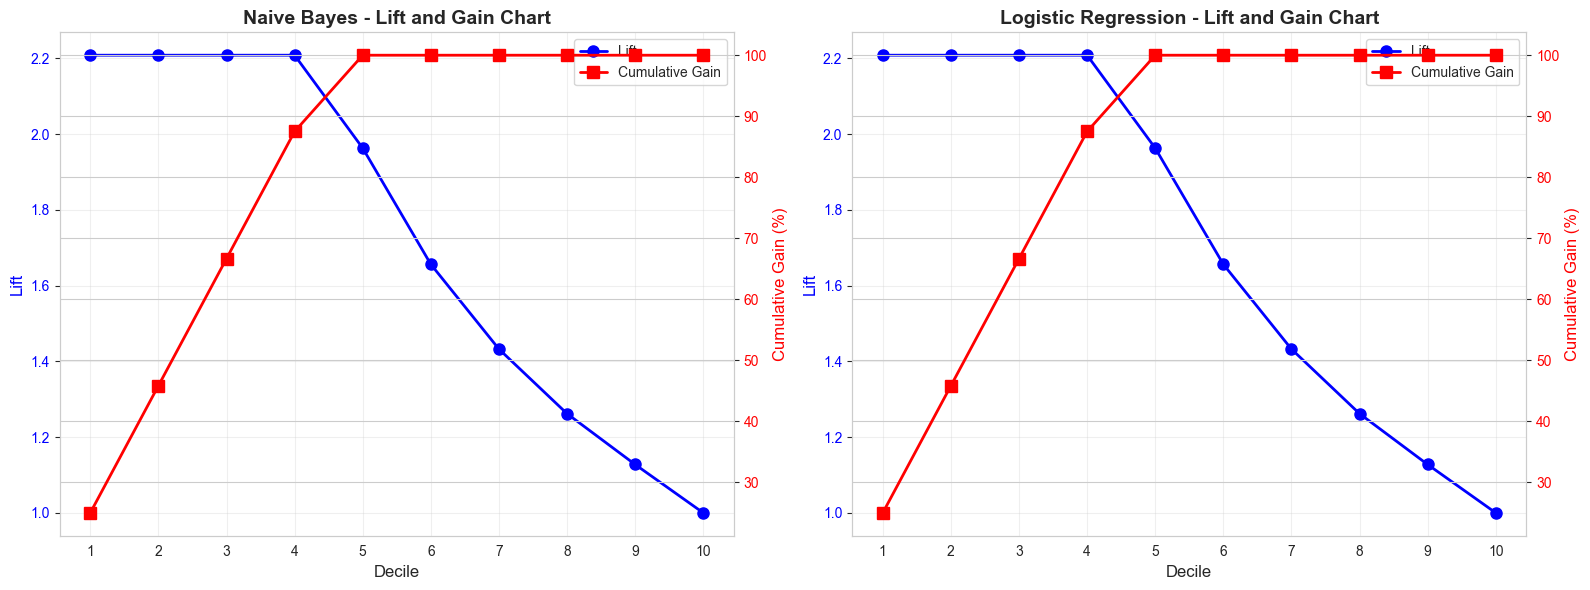

In [22]:
def calculate_lift_gain(y_true, y_proba, n_deciles=10):

    df = pd.DataFrame({
        'true': y_true,
        'proba': y_proba
    })
    
    # sort by prob
    df = df.sort_values('proba', ascending=False).reset_index(drop=True)
    
    # deciles
    df['decile'] = pd.qcut(df.index, n_deciles, labels=False, duplicates='drop') + 1
    
    # calc metrics per decile
    decile_stats = []
    total_positives = df['true'].sum()
    
    for decile in sorted(df['decile'].unique()):
        decile_data = df[df['decile'] <= decile]
        
        positives_captured = decile_data['true'].sum()
        total_captured = len(decile_data)
        cumulative_gain = (positives_captured / total_positives) * 100
        random_gain = (total_captured / len(df)) * 100
        lift = cumulative_gain / random_gain if random_gain > 0 else 0
        
        decile_stats.append({
            'decile': decile,
            'lift': lift,
            'cumulative_gain': cumulative_gain
        })
    
    return pd.DataFrame(decile_stats)

# lift & gain
print("\ncalculating lift & gain")


nb_lift_gain = calculate_lift_gain(y_test.values, nb_test_proba, n_deciles=10)
lr_lift_gain = calculate_lift_gain(y_test.values, lr_test_proba, n_deciles=10)

print("\nnb lift & gain per decile:")
print(nb_lift_gain.to_string(index=False))

print("\nlr lift & gain per decile:")
print(lr_lift_gain.to_string(index=False))

# plot
#NB
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1_twin = ax1.twinx()
line1 = ax1.plot(nb_lift_gain['decile'], nb_lift_gain['lift'], 
                 'b-o', linewidth=2, markersize=8, label='Lift')
line2 = ax1_twin.plot(nb_lift_gain['decile'], nb_lift_gain['cumulative_gain'], 
                      'r-s', linewidth=2, markersize=8, label='Cumulative Gain')

ax1.set_xlabel('Decile', fontsize=12)
ax1.set_ylabel('Lift', fontsize=12, color='b')
ax1_twin.set_ylabel('Cumulative Gain (%)', fontsize=12, color='r')
ax1.set_title('Naive Bayes - Lift and Gain Chart', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='b')
ax1_twin.tick_params(axis='y', labelcolor='r')
ax1.set_xticks(nb_lift_gain['decile'])
ax1.grid(True, alpha=0.3)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

# LR
ax2_twin = ax2.twinx()
line3 = ax2.plot(lr_lift_gain['decile'], lr_lift_gain['lift'], 
                 'b-o', linewidth=2, markersize=8, label='Lift')
line4 = ax2_twin.plot(lr_lift_gain['decile'], lr_lift_gain['cumulative_gain'], 
                      'r-s', linewidth=2, markersize=8, label='Cumulative Gain')

ax2.set_xlabel('Decile', fontsize=12)
ax2.set_ylabel('Lift', fontsize=12, color='b')
ax2_twin.set_ylabel('Cumulative Gain (%)', fontsize=12, color='r')
ax2.set_title('Logistic Regression - Lift and Gain Chart', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='b')
ax2_twin.tick_params(axis='y', labelcolor='r')
ax2.set_xticks(lr_lift_gain['decile'])
ax2.grid(True, alpha=0.3)

lines3, labels3 = ax2.get_legend_handles_labels()
lines4, labels4 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines3 + lines4, labels3 + labels4, loc='best')

plt.tight_layout()


### Lift and Gain evaluation

**Lift** (left y-axis): At each decile, Lift = (fraction of all positives captured in top *d*×10% of data) ÷ (*d*/10). Lift > 1 means the model concentrates positives in the top fraction better than random. (Lift = 1 is random).

**Cumulative Gain** (right y-axis): Fraction of all positives (Gentoos) captured when we take the top *d* deciles by predicted probability.

**Findings:** Lift starts high in the earliest deciles (the model concentrates Gentoos in the top-ranked fraction), then drops after the 4th decile as we include more of the population and the "bonus" over random shrinks. It reaches 1 at the 10th decile, when it has used 100% of the data and Lift equals the baseline. Gain starts at ~25% in the first decile (the top 10% of cases captures ~20% of all Gentoos), rises through deciles 2–5 as it accumulates more positives (Gentoos), and flattens at 100% by the 5th decile, meaning all Gentoos have been captured in the top half of the ranked list. Both models show these patterns and effectively prioritize the classification of the two species. The curves are similar for Naive Bayes and Logistic Regression, consistent with their matched accuracy and AUC.


## 4. Model Performance Comparison

**Overall comparison:** Across accuracy, AUC, and Lift/Gain, Naive Bayes and Logistic Regression perform **equally well** on Adelie vs Gentoo classification. Both achieve 100% accuracy on train and test, AUC = 1.0, and nearly identical Lift and Gain curves (Lift high in early deciles then declining to 1; Gain rising to 1.0 by the 5th decile and then flat).

**Which model performs better?** Neither—they perform the same on this task. Logistic Regression (LR) directly models P(Y|X), which is optimal for classification, while Naive Bayes makes assumptions that happened to align well with this data distribution. This data set was just particularly well suited for both models. Because accuracy, AUC, and Lift/Gain all agree, there is no metric where one model outperforms the other. On a harder task (e.g. including Chinstrap, or noisier data), we might see differences, but for Adelie vs Gentoo alone, both models do equally well at classifying the two species.

## 5. Complex Dataset (MINST)
Given the fact that I joined the class late, I'm just gonna use the semi-suggested MNIST model.

In [28]:
from sklearn.datasets import fetch_openml

print("\nloading MNIST")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X_mnist = mnist.data.values if hasattr(mnist.data, 'values') else mnist.data
y_mnist = mnist.target.values.astype(int) if hasattr(mnist.target, 'values') else mnist.target.astype(int)

print(f"MNIST dataset loaded: {X_mnist.shape}")

n_samples = 10000
X_mnist_subset = X_mnist[:n_samples]
y_mnist_subset = y_mnist[:n_samples]

print(f"subset of {n_samples} samples for analysis")
print(f"features: {X_mnist_subset.shape[1]} (28x28 pixel values)")
print(f"classes: {len(np.unique(y_mnist_subset))} (digits 0-9)")

# normalize pixel values to [0, 1]
X_mnist_subset = X_mnist_subset / 255.0

# train/test split
X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist = train_test_split(
    X_mnist_subset, y_mnist_subset, test_size=0.2, random_state=42, stratify=y_mnist_subset
)

print(f"\nMNIST training set size: {X_train_mnist.shape[0]}")
print(f"MNIST test set size: {X_test_mnist.shape[0]}")

# train models
print("\ntraining models")

nb_mnist = GaussianNB()
nb_mnist.fit(X_train_mnist, y_train_mnist)
lr_mnist = LogisticRegression(random_state=42, max_iter=1000)
lr_mnist.fit(X_train_mnist, y_train_mnist)

# predict
nb_train_pred_mnist = nb_mnist.predict(X_train_mnist)
nb_test_pred_mnist = nb_mnist.predict(X_test_mnist)
lr_train_pred_mnist = lr_mnist.predict(X_train_mnist)
lr_test_pred_mnist = lr_mnist.predict(X_test_mnist)

# calc accuracies
nb_train_accuracy_mnist = accuracy_score(y_train_mnist, nb_train_pred_mnist)
nb_test_accuracy_mnist = accuracy_score(y_test_mnist, nb_test_pred_mnist)
lr_train_accuracy_mnist = accuracy_score(y_train_mnist, lr_train_pred_mnist)
lr_test_accuracy_mnist = accuracy_score(y_test_mnist, lr_test_pred_mnist)

print("\nNB:")
print(f"  Training Accuracy: {nb_train_accuracy_mnist:.4f} ({nb_train_accuracy_mnist*100:.2f}%)")
print(f"  Test Accuracy:     {nb_test_accuracy_mnist:.4f} ({nb_test_accuracy_mnist*100:.2f}%)")

print("\nLR:")
print(f"  Training Accuracy: {lr_train_accuracy_mnist:.4f} ({lr_train_accuracy_mnist*100:.2f}%)")
print(f"  Test Accuracy:     {lr_test_accuracy_mnist:.4f} ({lr_test_accuracy_mnist*100:.2f}%)")

# AUC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test_bin = label_binarize(y_test_mnist, classes=np.unique(y_mnist_subset))

# prob predictions
nb_test_proba_mnist = nb_mnist.predict_proba(X_test_mnist)
lr_test_proba_mnist = lr_mnist.predict_proba(X_test_mnist)

# AUC
nb_auc_mnist = roc_auc_score(y_test_bin, nb_test_proba_mnist, average='macro', multi_class='ovr')
lr_auc_mnist = roc_auc_score(y_test_bin, lr_test_proba_mnist, average='macro', multi_class='ovr')
print(f"\nNB AUC: {nb_auc_mnist:.4f}")
print(f"LR AUC: {lr_auc_mnist:.4f}")

# confusion matrices
nb_cm_mnist = confusion_matrix(y_test_mnist, nb_test_pred_mnist)
lr_cm_mnist = confusion_matrix(y_test_mnist, lr_test_pred_mnist)

print("\nNB Confusion Matrix:")
print(nb_cm_mnist)
print("\nLR Confusion Matrix:")
print(lr_cm_mnist)




loading MNIST
MNIST dataset loaded: (70000, 784)
subset of 10000 samples for analysis
features: 784 (28x28 pixel values)
classes: 10 (digits 0-9)

MNIST training set size: 8000
MNIST test set size: 2000

training models

NB:
  Training Accuracy: 0.6091 (60.91%)
  Test Accuracy:     0.5930 (59.30%)

LR:
  Training Accuracy: 0.9755 (97.55%)
  Test Accuracy:     0.9010 (90.10%)

NB AUC: 0.9174
LR AUC: 0.9915

NB Confusion Matrix:
[[180   0   1   1   0   1   4   0  13   0]
 [  0 216   1   0   0   0   1   1   6   0]
 [ 10  18  95   4   2   3  31   1  33   1]
 [ 10  21   8  58   2   1   4   2  86  14]
 [  4   7   4   0  51   1   6   2  50  71]
 [ 18  17   1   4   0  20   5   0 100   8]
 [  3   7   2   0   0   0 188   0   3   0]
 [  0  14   1   1   5   0   0  80   2 111]
 [  2  43   2   2   2   3   2   0 127   6]
 [  1  16   0   1   2   0   0   2   3 171]]

LR Confusion Matrix:
[[197   0   0   1   0   0   1   0   1   0]
 [  0 217   1   2   0   3   0   0   2   0]
 [  2   3 167   2   4   1   4

### Analysis

The results reveal a huge performance gap between the two models on the MNIST dataset. LR has a 90.10% accuracy which is an incredibly strong performance, while NB achieves a 59.3% accuracy which is barely better than random (which would be 50%).

NB assumes features are conditionally independent given the class which is fine for the penguins which have independent numeric measurements, but in the MNIST dataset adjacent pixels ARE correlated (as they are pictures), so this assumption does not work. The confusion matrix shows that it has a bunch of misclassifications, specifically looking at digit 3, which is row 4, where only 58/206 were correct. It does so poorly because NB can't understand that specific pixel combinations define digit shapes.

LR looks at probability of the class given the features, which means it only needs to find decision boundaries that separate classes. This means LR can learn patterns that form certain digits & learns weights for each pixel that work together. Looking at the confusion matrix, LR shows a strong diagonal showing that most predictions were correct.